In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp core

# core

> core routines

In [ ]:
#|hide
from nbdev.showdoc import *

In [ ]:
#|export 
import torch
import torchaudio
from torchaudio import transforms as T
from torch.nn import functional as F
import numpy as np
from librosa import load as lr_load
from pedalboard.io import AudioFile, get_supported_read_formats
import os
import math
from einops import rearrange
import random
import string
import glob

In [ ]:
#|export
def get_device(gpu_str=''):
    "utility to suggest which pytorch device to use"
    #return torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
    device_str = 'cpu'
    if torch.cuda.is_available():
        device_str = 'cuda' if gpu_str=='' else f'cuda:{gpu_str}'
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available(): # must check for mps attr if using older pytorch
        device_str = 'mps'
        os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
    return torch.device(device_str)

In [ ]:
get_device()

device(type='cuda')

In [ ]:
#|export
def is_tool(name):
    """Check whether `name` is on PATH and marked as executable."""

    # from whichcraft import which
    from shutil import which

    return which(name) is not None

In [ ]:
is_tool('ffmpeg')

True

In [ ]:
#|export
def normalize_audio(
    audio_in,       # input array/tensor  (numpy or Pytorch)
    norm='global', # global (use max-abs of whole clip) | channel (per-channel norm'd individually) | ''/None
    ):
    "normalize audio, based on the max of the absolute value"
    audio_out = audio_in.clone() if torch.is_tensor(audio_in) else audio_in.copy()  # rudimentary PyTorch/NumPy support
    if ('global' == norm) or  len(audio_in.shape)< 2:
        absmax = abs(audio_in).max()
        audio_out = 0.99*audio_in/absmax if absmax != 0 else audio_in  # 0.99 = just below clipping
    elif 'channel' == norm:
        for c in range(audio_in.shape[0]):  # this loop is slow but sure. TODO: do it fast but still avoid div by zero
            absmax = abs(audio_in[c]).max()
            audio_out[c] = 0.99*audio_in[c]/absmax if absmax != 0 else audio_in[c]  # 0.99 = just below clipping
      #anything else, pass unchanged
    return audio_out

Testing `normalize_audio`: 

In [ ]:
#|hide
import matplotlib.pyplot as plt 

In [ ]:
#|hide
def plot_norm_inout(y, y2):
    x = np.arange(y.shape[-1])
    if len(y.shape) < 2:
        plt.plot(y,'o-', label=f'y_Original')
        plt.plot(y2,'s-', label=f'y_Normalized')        
    else: 
        for c in range(y.shape[0]): #loop over channels
            plt.plot(y[c],'o-', label=f'y_{c}_Original')
            plt.plot(y2[c],'s-', label=f'y_{c}_Normalized')
    plt.legend()
    plt.show() 

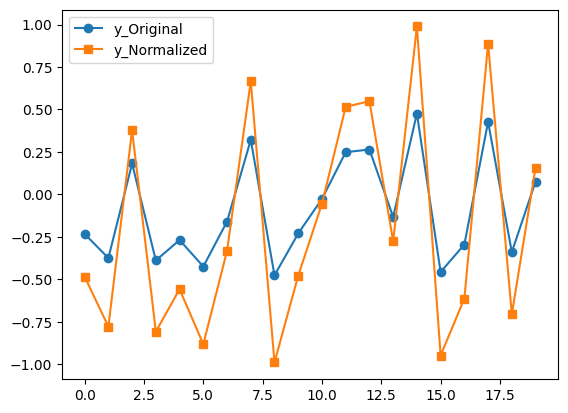

In [ ]:
y = np.random.rand(20)-0.5  # mono
y2 = normalize_audio(y)
plot_norm_inout(y, y2) # I wrote a little test function just to plot these for the documentation; not part of aeiou

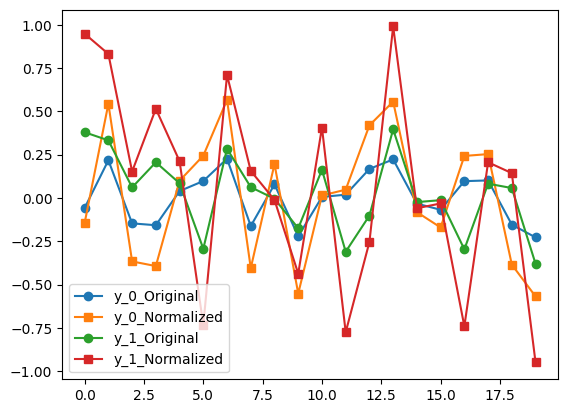

In [ ]:
y = np.random.rand(2,20)-0.5  # stereo
y[0,:] *= 0.5     # but make one channel smaller for show 
y2 = normalize_audio(y)   # global norm, the default
plot_norm_inout(y, y2)

See how the orange-squares line above is bigger than the corresponding blue-squares line, but the orange one doesn't go all the way to +/-1?   Contrast that with the following below where we normalize the same input signal per channel:

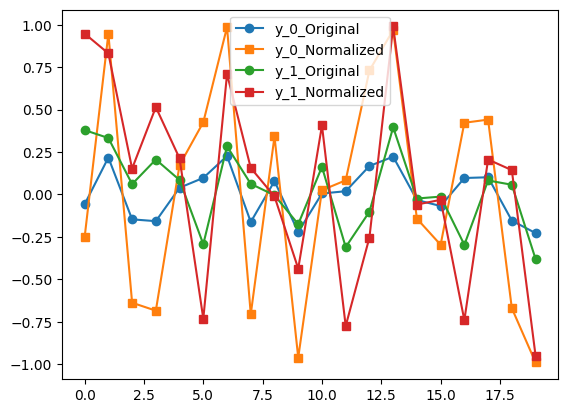

In [ ]:
y2 = normalize_audio(y, norm='channel')   # per-channel norm
plot_norm_inout(y, y2)

.... the orange-squares line now extends to the full range. 

## load_audio
We'll start with a basic utilty to read an audio file.  If it's not at the sample rate we want, we'll automatically resample it.  Note that if you want MP3 support, you'll need to install `ffmpeg` system-wide first. 

In [ ]:
#|export

pdlbd_exts = None      # stores supported pedalboard file extensions. Global so it updates once per run

def load_audio(
    filename:str,     # name of file to load
    sr=48000,         # sample rate in Hz
    verbose=True,     # whether or not to print notices of resampling
    norm='',          # passedto normalize_audio(), see above
    )->torch.tensor:
    "loads an audio file as a torch tensor"
    global pdlbd_exts
    
    if '.mp3' in filename.lower():  # don't rely on torchaudio for mp3s
        pdlbd_exts = get_supported_read_formats() if pdlbd_exts==None else pdlbd_exts
        if '.mp3' in pdlbd_exts:   # first try pedalboard's mp3 support
            with AudioFile(filename) as f:
                audio, in_sr = f.read(f.frames), f.samplerate
        else:
            if verbose: print("Warning: pedalboard mp3 support failed, falling back to librosa")
            audio, in_sr = lr_load(filename, mono=False, sr=sr)
        audio = torch.tensor(audio)
    else:
        audio, in_sr = torchaudio.load(filename)
    if in_sr != sr:
        if verbose: print(f"Resampling {filename} from {in_sr} Hz to {sr} Hz",flush=True)
        resample_tf = T.Resample(in_sr, sr)
        audio = resample_tf(audio)
        
    if norm in ['global','channel']: audio = normalize_audio(audio, norm=norm)
    return audio

Using the file in `examples/`, let's see how this works:

In [ ]:
#| eval: false
audio = load_audio('examples/example.wav')

Resampling examples/example.wav from 44100 Hz to 48000 Hz


In [ ]:
#| eval: false
audio = load_audio('examples/example.wav',verbose=False)

Let's check to see if we can read MP3s:

In [ ]:
#| eval: false
for norm in ['','global','channel']:
    audio = load_audio('examples/stereo_pewpew.mp3',verbose=False, norm=norm)
    print(f"norm = {norm}: shape = ",audio.shape, "Per-channel abs-maxes are : ", np.abs(audio.numpy()).max(axis=-1))

norm = : shape =  torch.Size([2, 236983]) Per-channel abs-maxes are :  [0.8505264  0.50114477]
norm = global: shape =  torch.Size([2, 236983]) Per-channel abs-maxes are :  [0.98999995 0.583325  ]
norm = channel: shape =  torch.Size([2, 236983]) Per-channel abs-maxes are :  [0.98999995 0.99      ]


Note that `pedalboard` *could* be used to read any of the following types of files...

In [ ]:
#| eval: false
print(pdlbd_exts)

['.aif', '.aiff', '.bwf', '.flac', '.mp3', '.ogg', '.wav']


...but we're only using it for MP3s right now, and `torchaudio` for everything else.

## get_dbmax

Finds loudest sample value in the entire clip and returns the value as decibels  

In [ ]:
#|export
def get_dbmax(
    audio,       # torch tensor of (multichannel) audio
    ):
    "finds the loudest value in the entire clip and puts that into dB (full scale)"
    return 20*torch.log10(torch.flatten(audio.abs()).max()).cpu().numpy()

In [ ]:
#| eval: false
print("dbmax of last-loaded audio is",get_dbmax(audio))

dbmax of last-loaded audio is -0.08729602210223675


## is_silence

Sometimes we'll want to know if a file is "silent", i.e. if its contents are quieter than some threshold.  Here's one simple way to implement that:

In [ ]:
#|export
def audio_float_to_int(waveform):
    "converts torch float to numpy int16 (for playback in notebooks)"
    return np.clip( waveform.cpu().numpy()*32768 , -32768, 32768).astype('int16')

In [ ]:
#| eval: false
print(audio.dtype)
print(audio_float_to_int(audio).dtype)

torch.float32
int16


In [ ]:
#|export
def is_silence(
    audio,       # torch tensor of (multichannel) audio
    thresh=-60,  # threshold in dB below which we declare to be silence
    ):
    "checks if entire clip is 'silence' below some dB threshold"
    dBmax = get_dbmax(audio)
    return dBmax < thresh

Let's test that with some tests.  If all goes well, the following `assert` statements will all pass uneventfully. 

In [ ]:
x = torch.ones((2,10))
assert not is_silence(1e-3*x) # not silent
assert is_silence(1e-5*x) # silent
assert is_silence(1e-3*x, thresh=-50) # higher thresh

## batch_it_crazy
This is a pretty basic utility for breaking up a long sequence into batches, e.g. for model inference

In [ ]:
#|export
def batch_it_crazy(
    x,        # a time series as a PyTorch tensor, e.g. stereo or mono audio
    win_len,  # length of each "window", i.e. length of each element in new batch
    ):
    "(pun intended) Chop up long sequence into a batch of win_len windows"
    if len(x.shape) < 2: x = x.unsqueeze(0)  # guard against 1-d arrays
    x_len = x.shape[-1]
    n_windows = (x_len // win_len) + 1
    pad_amt = win_len * n_windows - x_len  # pad end w. zeros to make lengths even when split
    xpad = F.pad(x, (0, pad_amt))
    return rearrange(xpad, 'd (b n) -> b d n', n=win_len)

Testing `batch_it_crazy()` for stereo input: 

In [ ]:
x = torch.ones([2,1000])  # stereo
batch_it_crazy(x, 10).shape

torch.Size([101, 2, 10])

...and for mono: 

In [ ]:
x = torch.ones([1000])   # mono
batch_it_crazy(x, 10).shape

torch.Size([101, 1, 10])

...and yeah, currently that "` 1,`" stays because other parts of the code(s) will be assuming "multichannel" audio. 

## makedir 
The next routine creates a directory if it doesn't already exist.  We'll even let it take a "nested" directory such as `a/b/c/d` and the routine will create any directories in that string.

In [ ]:
#|export
def makedir(
    path:str,              # directory or nested set of directories
    ):
    "creates directories where they don't exist"
    if os.path.isdir(path): return  # don't make it if it already exists
    #print(f"  Making directory {path}")
    try:
        os.makedirs(path)  # recursively make all dirs named in path
    except:                # don't really care about errors
        pass

## get_audio_filenames
Often we'll want to grab a long list of audio filenames by looking through a directory and all its subdirectories.  We could use something like `glob`, `glob` turns out to be extremely slow when large numbers of files (say, more than 100,000) are involved.  Instead we will use the much faster `os.scandir()`, which was packaged nicely into the following routine in [an answer to a StackOverflow question](https://stackoverflow.com/a/59803793/4259243) from which this code is modified:

In [ ]:
#|export
def fast_scandir(
    dir:str,  # top-level directory at which to begin scanning
    ext:list  # list of allowed file extensions
    ):
    "very fast `glob` alternative. from https://stackoverflow.com/a/59803793/4259243"
    subfolders, files = [], []
    ext = ['.'+x if x[0]!='.' else x for x in ext]  # add starting period to extensions if needed
    try: # hope to avoid 'permission denied' by this try
        for f in os.scandir(dir):
            try: # 'hope to avoid too many levels of symbolic links' error
                if f.is_dir():
                    subfolders.append(f.path)
                elif f.is_file():
                    if os.path.splitext(f.name)[1].lower() in ext:
                        files.append(f.path)
            except:
                pass 
    except:
        pass

    for dir in list(subfolders):
        sf, f = fast_scandir(dir, ext)
        subfolders.extend(sf)
        files.extend(f)
    return subfolders, files

Quick test:

In [ ]:
_, files = fast_scandir('examples/', ['wav','flac','ogg','aiff','aif','mp3'])
files

['examples/stereo_pewpew.mp3', 'examples/example.wav']

Often, rather than being given a single parent directory, we may be given a list of directories in which to look for files.  The following just called `fast_scandir()` for each of those:

In [ ]:
#|export
def get_audio_filenames(
    paths:list   # directories in which to search
    ):
    "recursively get a list of audio filenames"
    filenames = []
    if type(paths) is str: paths = [paths]
    for path in paths:               # get a list of relevant filenames
        subfolders, files = fast_scandir(path, ['.wav','.flac','.ogg','.aiff','.aif','.mp3'])
        filenames.extend(files)
    return filenames

Here's a fun trick to show off how fast this is: Run in the user's directory tree:

In [ ]:
path = str(os.path.expanduser("~"))+'/Downloads'
if os.path.exists(path):
    files = get_audio_filenames(path)
    print(f"Found {len(files)} audio files.")
else:
    print("Ok it was just a thought.")

Ok it was just a thought.


In [ ]:
#|export
def untuple(x, verbose=False):
    """Recursive.  For when you're sick of tuples and lists: 
    keeps peeling off elements until we get a non-tuple or non-list, 
    i.e., returns the 'first' data element we can 'actually use'"""
    if isinstance(x, tuple) or isinstance(x, list): 
        if verbose: print("yea: x = ",x)
        return untuple(x[0], verbose=verbose)
    else:
        if verbose: print("no: x = ",x)
        return x

In [ ]:
a = [[((5,6),7)]]
print(a)
print(untuple(a, verbose=True))

[[((5, 6), 7)]]
yea: x =  [[((5, 6), 7)]]
yea: x =  [((5, 6), 7)]
yea: x =  ((5, 6), 7)
yea: x =  (5, 6)
no: x =  5
5


## Run Names and Checkpointing
in concert with Pytorch Lightning

In [ ]:
#|export
def get_latest_ckpt(
    dir_tree,            # name of the group of runs without run name or unique identifer
    run_name_prefix='',  # run name without unique identifier for particular run
    verbose=True  # whether to pring message(s)
    ):
    "This will grab the most recent checkpoint filename in dir tree given by name"
    search_string = f"{dir_tree}/{run_name_prefix}*/checkpoints/*.ckpt"
    if verbose: print(f"Looking for latest checkpoint in {search_string}")
    list_of_files = glob.glob(search_string, recursive=True) 
    if [] == list_of_files:
        print("WARNING: No matching checkpoint files found. Starting run from scratch.") 
        return ""
    else:
        return max(list_of_files, key=os.path.getctime)

In [ ]:
#testing
name = '/fsx/shawley/runs/longer-songs2-stacked-clap-audio'
ckpt_path = get_latest_ckpt(name, run_name_prefix='')
ckpt_path

Looking for latest checkpoint in /fsx/shawley/runs/longer-songs2-stacked-clap-audio/*/checkpoints/*.ckpt


'/fsx/shawley/runs/longer-songs2-stacked-clap-audio/songlike_324xavvk/checkpoints/last.ckpt'

In [ ]:
#|export
def rnd_string(n=8): 
    "random letters and numbers of given length. case sensitive"
    return ''.join(random.choice(string.ascii_letters+string.digits) for i in range(n))

def get_run_name(run_name_prefix='', n=8):
    "prepends run name prefix to random string. Alternative to PL/WandB random run names" 
    return run_name_prefix+'_'+rnd_string(n) if run_name_prefix !='' else rnd_string(n)

In [ ]:
get_run_name('songlike')

'songlike_IsUUvn8u'

Sample usage of the previous few functions:

```python
# Where to save NEW checkpoints
run_name = get_run_name(run_name_prefix=args.run_name) # add unique identifier
print(f"run_name = {run_name}")
ckpt_dir = f"{args.name}/{run_name}/checkpoints" 
ckpt_callback = pl.callbacks.ModelCheckpoint(dirpath=ckpt_dir, every_n_train_steps=args.checkpoint_every, save_top_k=-1, save_last=True)

# Reading from OLD checkpoint to start
grab_latest_checkpoint = True
if grab_latest_checkpoint:
    ckpt_path = get_latest_ckpt(args.name, run_name_prefix=args.run_name) 
    if os.path.exists(ckpt_path):
        print(f"Found latest checkpoint at {ckpt_path}")
        args.ckpt_path = ckpt_path
if args.ckpt_path:
    print(f"Loading Model from {args.ckpt_path}")
    model = OurModel.load_from_checkpoint(args.ckpt_path, stuff=stuff)
else:
    model = OurModel(stuff=stuff)
```

In [ ]:
#| hide
from nbdev import nbdev_export
nbdev_export()